# XGBoost

In [1]:
# Load libraries 
# Data processing 
import pandas as pd

# Statistics
import scipy as sp
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# Machine learning & Deep learning
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import manifold
from sklearn.cross_validation import KFold
import xgboost as xgb

# Grid Search & Cross Validation
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

### Import dataset and make it into DataFrame

In [2]:
# import dataset
data = pd.read_csv('/home/stan/Documents/dev/Time_Series/10YearsFeaturesCorn.csv')
data.index = pd.to_datetime(data['Date'])
data.sort_index(inplace=True, ascending=True)
data.head()

,Date,Corn,Ethanol,Crude Oil,Live Cattle,ADM,Bunge,Con Agra,Green Plains,Wheat,Soyabean
Date,,,,,,,,,,,
2006-03-31,31/03/06,227.25,2.43,61.95,87.35,31.72,56.79,21.14,59.97,367.50,580.00
2006-04-30,30/04/06,235.25,2.62,66.30,79.50,34.75,55.71,21.50,33.75,344.50,570.50
2006-05-31,31/05/06,237.25,2.72,71.98,73.65,36.85,53.18,22.64,41.00,349.00,585.00
2006-06-30,30/06/06,251.25,3.98,70.25,79.75,42.22,56.63,22.60,35.00,394.25,580.25
2006-07-31,31/07/06,239.25,3.22,73.26,85.80,41.70,50.26,22.15,34.85,371.50,602.50


In [90]:
data.shape

(120, 11)

Split date information into 3 columns

In [94]:
data['Day'] = data['Date'].str.split('/').apply(lambda x: float(x[0]))
data['Month'] = data['Date'].str.split('/').apply(lambda x: float(x[1]))
data['Year'] = data['Date'].str.split('/').apply(lambda x: float(x[2]))

In [95]:
data.tail()

,Date,Corn,Ethanol,Crude Oil,Live Cattle,ADM,Bunge,Con Agra,Green Plains,Wheat,Soyabean,Day,Month,Year
Date,,,,,,,,,,,,,,
2015-10-31,31/10/15,387.75,1.57,48.40,124.00,41.69,73.43,40.48,19.69,512.00,891.50,31,10,15
2015-11-30,30/11/15,381.25,1.61,49.50,141.13,45.81,72.86,41.10,20.33,520.00,883.75,30,11,15
2015-12-31,31/12/15,365.25,1.53,44.62,129.45,36.80,67.00,41.12,24.16,460.00,881.00,31,12,15
2016-01-31,31/01/16,359.50,1.38,37.85,135.58,36.11,67.48,41.69,22.55,472.75,870.75,31,1,16
2016-02-29,29/02/16,371.00,1.41,35.85,135.80,34.77,61.89,41.52,18.48,476.25,883.00,29,2,16


In [96]:
data.dtypes

Date             object
Corn            float64
Ethanol         float64
Crude Oil       float64
Live Cattle     float64
ADM             float64
Bunge           float64
Con Agra        float64
Green Plains    float64
Wheat           float64
Soyabean        float64
Day             float64
Month           float64
Year            float64
dtype: object

#### Derive train and test samples

In [97]:
# make copy for sample selection
df = data.copy()

In [98]:
# Train test split
df.drop(['Date'], axis=1, inplace=True)
X_train = df[:-12]
y_train = X_train['Corn']
X_train.drop(['Corn'], axis=1, inplace=True)

X_test = df[-12:]

/usr/share/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
X_test

,Corn,Ethanol,Crude Oil,Live Cattle,ADM,Bunge,Con Agra,Green Plains,Wheat,Soyabean,Day,Month,Year
Date,,,,,,,,,,,,,
2015-03-31,383.00,1.44,62.50,152.18,47.82,81.51,34.82,23.23,517.25,1029.75,31,3,15
2015-04-30,377.00,1.49,55.18,161.40,47.45,82.52,36.51,28.26,513.00,973.25,30,4,15
2015-05-31,362.50,1.63,66.78,149.50,48.91,86.97,36.10,31.18,469.50,979.75,31,5,15
2015-06-30,350.50,1.52,65.59,152.58,52.89,92.61,38.85,32.44,478.00,931.00,30,6,15
2015-07-31,411.00,1.62,63.02,148.40,48.71,88.40,43.90,27.80,611.50,1053.50,31,7,15
2015-08-31,370.00,1.48,51.55,147.45,47.42,79.72,44.01,22.22,497.25,978.00,31,8,15
2015-09-30,362.50,1.47,52.92,142.83,43.98,71.50,40.98,20.61,482.00,891.75,30,9,15
2015-10-31,387.75,1.57,48.40,124.00,41.69,73.43,40.48,19.69,512.00,891.50,31,10,15
2015-11-30,381.25,1.61,49.50,141.13,45.81,72.86,41.10,20.33,520.00,883.75,30,11,15


all those values above are not known (except the dates) at prediction time; we need to forecast those values

#### General purpose function to apply Box-Jenkins procedure to obtain ARIMA forecasts of feature time series

In [152]:
def predict_ts(ts,name):
    flag=True
    d=0
    org_ts=ts.copy()
    #difference ts
    while(flag):
        regres = sm.tsa.stattools.adfuller(ts, regression='ct', regresults=True)
        if regres[1]<0.05:
            flag=False
        else:
            ts=ts.diff(1).dropna()
            d+=1
    #select p and q
    try:
        pqselect = sm.tsa.stattools.arma_order_select_ic(ts)
        p,q=pqselect.bic_min_order
        if p==0 and q==0:
            p=0
            q=5
    except:
        p=0
        q=5
    try:
        arima = sm.tsa.ARIMA(org_ts,(p,d,q)).fit()
    except:
        arima = sm.tsa.ARIMA(org_ts,(p,d+1,q)).fit()
    dw = sm.stats.durbin_watson(arima.resid.values)
    forecast = arima.forecast(12)[0]
    return {'name':name, 'prediction':forecast, 'spec': (p,d,q), 'dw': dw}

Create a new dataframe to store forecasted values of feature time series

In [153]:
df_te = pd.DataFrame(index=X_test.index, columns=X_test.columns)

Can copy date features as those can be inferred

In [154]:
df_te['Day']=X_test['Day']
df_te['Month']=X_test['Month']
df_te['Year']=X_test['Year']

Fill in the new feature matrix

In [155]:
list_of_results=[]
for feat in ['Ethanol', 'Crude Oil', 'Live Cattle', 'ADM', 'Bunge', 'Con Agra', 'Green Plains', 'Green Plains',
             'Wheat','Soyabean']:
    res = predict_ts(X_train[feat], feat)
    list_of_results.append(res)
    df_te[feat]=res['prediction']

/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/share/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to conver

#### Forecasted values:

In [156]:
df_te.head()

,Corn,Ethanol,Crude Oil,Live Cattle,ADM,Bunge,Con Agra,Green Plains,Wheat,Soyabean,Day,Month,Year
Date,,,,,,,,,,,,,
2015-03-31,NaN,1.567223,50.634136,154.214957,46.304555,90.203766,35.853304,24.076855,473.234959,990.814076,31,3,15
2015-04-30,NaN,1.699310,49.815050,156.571901,47.478204,90.609040,36.326636,24.106427,514.463675,989.645207,30,4,15
2015-05-31,NaN,1.797656,49.452831,157.386165,46.590952,91.015821,36.904162,24.307256,506.985234,998.151414,31,5,15
2015-06-30,NaN,1.870780,49.260756,157.799989,46.634931,91.424110,36.724196,24.496798,527.116756,1002.093959,30,6,15
2015-07-31,NaN,1.925051,49.132044,160.098800,47.768967,91.833906,36.502100,24.726435,504.899658,1007.610186,31,7,15


In [157]:
df_te.drop('Corn', axis=1, inplace=True)

#### Configure XGBoost

In [171]:
param={
    'objective': 'reg:linear',
    'base_score': 0.5,
    'missing': None,
    'nthread': -1,
    'reg_alpha': 0,
    'reg_lambda': 0.1,
    'seed': 1,
    'silent': 0,
}

Build xgboost model

In [172]:
xgb_model = xgb.XGBRegressor(**param)
clf = xgb_model.fit(X_train,y_train)

In [173]:
tr_accuracy = clf.score(X_train,y_train)
print("XGBoost Train Accuracy: {:.4f}".format(tr_accuracy))
# 0.8309

XGBoost Train Accuracy: 0.9989


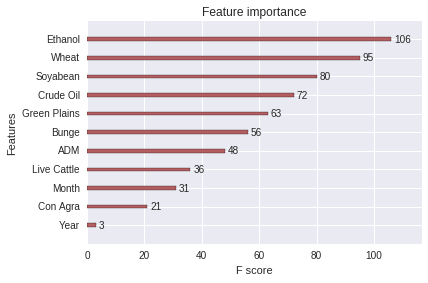

In [174]:
plt.figure(figsize=(20,15))
xgb.plot_importance(clf,color='#b45e62')

This is real time series of corn prices in the test set:

In [175]:
X_test['Corn']

Date
2015-03-31    383.00
2015-04-30    377.00
2015-05-31    362.50
2015-06-30    350.50
2015-07-31    411.00
2015-08-31    370.00
2015-09-30    362.50
2015-10-31    387.75
2015-11-30    381.25
2015-12-31    365.25
2016-01-31    359.50
2016-02-29    371.00
Name: Corn, dtype: float64

In [176]:
pred = clf.predict(df_te)

Those are predicted values based on xgboost model and forecasted features:

In [177]:
pred

array([ 378.49481201,  372.75744629,  377.89331055,  380.18914795,
        370.50238037,  368.6619873 ,  369.42169189,  370.55703735,
        373.38235474,  374.81079102,  381.23071289,  381.75900269], dtype=float32)

#### Evaluate performance

In [178]:
def evaluate_prediction(te_data,predict):
    err = np.subtract(te_data.values.flatten(), predict.flatten())
    abserr = np.absolute(err)
    mae = np.mean(abserr)
    perc_err = np.divide(abserr, te_data.values.flatten())
    perc_mae = np.mean(perc_err)
    return mae, perc_mae

In [179]:
mae, perc_mae = evaluate_prediction(X_test['Corn'], pred)

In [180]:
mae

14.141553243001303

In [181]:
perc_mae

0.037669213401643059

This is the specifications of the ARIMA models used to derive forecasts of commodity prices time- series

In [182]:
list_of_results

[{'dw': 2.1122330028894183,
  'name': 'Ethanol',
  'prediction': array([ 1.56722332,  1.69931014,  1.79765631,  1.87078049,  1.9250506 ,
          1.96522682,  1.99486752,  2.01663264,  2.03251057,  2.04398769,
          2.05217508,  2.05790332]),
  'spec': (1, 1, 1)},
 {'dw': 2.0202342406913854,
  'name': 'Crude Oil',
  'prediction': array([ 50.63413605,  49.81504997,  49.45283145,  49.26075618,
          49.13204441,  49.02693001,  48.93060356,  48.83754985,
          48.74571496,  48.65433397,  48.56312202,  48.47197302]),
  'spec': (1, 1, 0)},
 {'dw': 1.9321332576300958,
  'name': 'Live Cattle',
  'prediction': array([ 154.21495671,  156.57190099,  157.38616457,  157.79998904,
          160.09880034,  160.77762832,  161.45645629,  162.13528427,
          162.81411225,  163.49294023,  164.1717682 ,  164.85059618]),
  'spec': (0, 1, 5)},
 {'dw': 1.9199746710056829,
  'name': 'ADM',
  'prediction': array([ 46.30455515,  47.4782037 ,  46.59095205,  46.63493149,
          47.76896745,  

## END OF NOTEBOOK

Multilayer perceptron specification for the currently in development version of numpy

In [44]:
#MLP Regressor
from sklearn.neural_network import MLPRegressor

ImportError: cannot import name 'MLPRegressor'

In [ ]:
from sklearn.preprocessing import StandardScaler
#same scaler need to be applied to both test and train
scaler = StandardScaler()  
#fir on train
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(5, ), activation='relu', algorithm='l-bfgs', alpha=0.0001,\
                   batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5,\
                   max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False,\
                   momentum=0.9, nesterovs_momentum=True, early_stopping=True, validation_fraction=0.1,\
                   beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
reg.fit(X_train, y_train)
yhat=reg.predict(X_test)